Documentation: https://altair-viz.github.io/getting_started/overview.html

**Note: You need to run this code in the command line before the above will work: conda install -c conda-forge altair vega_datasets notebook vega**

In [3]:
import altair as alt
import pandas as pd
from scipy.stats import pearsonr

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

### Read the excel file and csv file into pandas dataframes
Look at your current working directory (!pwd) to know what filepath to pass into read_excel()

In [4]:
clinicaldf = pd.read_excel('UCEC_clinical_genotype_phenotype_V1.1.tsi.xlsx', sheet_name="CPTAC3_UCEC_clinical_genotypes_")
clinicaldf.drop(clinicaldf.index[0], inplace=True)
clinicaldf.head()

,idx,Histologic_Grade_(FIGO),Histologic_Type,Num_full_term_pregnancies,Tumor_Size_(cm),FIGO_stage,Myometrial_invasion_Specify,Diabetes,BMI,LVSI,...,PI3K-PTEN,PI3K-PIK3R2,TP53-ATM,TP53-TP53,TP53-TP53_pathway,HRD-BRCA1,HRD-BRCA1_or_BRCA2,HRD-BRCA2,MSI,POLE
1,C3L-00006,1,0,1,2.9,0,1,0,38.88,1,...,1,0,0,1,1,0,0,0,1,0
2,C3L-00008,1,0,1,3.5,0,1,0,39.76,0,...,1,0,0,0,0,0,0,0,1,0
3,C3L-00032,2,0,4,4.5,0,1,1,51.19,0,...,0,0,0,0,0,0,0,0,0,0
4,C3L-00090,2,0,4,3.5,0,1,1,32.69,0,...,1,0,0,0,0,0,0,0,0,0
5,C3L-00098,3,0,2,6,0,1,0,20.28,NaN,...,0,0,0,1,1,0,0,0,0,0


**Note: In order to read a .cct file, first change the extension to .csv then import into Excel (File --> import --> CSV File, choose file, select Delimited, click "Next", check the box next to "Space", click "Finish")**

In [5]:
phosdf = pd.read_excel('UCEC_phosphoproteomics_site_level_V1.xlsx', sheet_name="data")
phosdf.head()

,idx,C3L-00136.T,C3L-00098.T,C3L-00090.T,C3L-00008.T,C3L-00032.T,C3L-00006.T,C3L-00006.N,C3L-00139.T,C3L-00143.T,...,C3N-01349.T,C3N-03320.N,C3N-03411.N,NM_Mix1.N,C3N-03691a.N,C3N-03691b.N,C3N-03692.N,C3L-03601a.N,C3L-03601b.N,NM_Mix2.N
0,AAAS-S495,NaN,1.511548,1.112944,NaN,0.817520,NaN,NaN,1.418852,0.869111,...,0.987610,0.860698,0.567761,0.589163,0.655917,0.576749,0.945281,NaN,NaN,1.037036
1,AAK1-S18,0.879774,1.556005,NaN,0.692318,1.334778,0.821719,1.107258,1.336072,0.726407,...,1.004323,0.820971,0.930256,0.855603,1.676428,1.227982,1.139254,1.418611,1.994327,0.665400
2,AAK1-S20,0.696099,0.964754,0.687200,0.453538,0.966963,1.352040,0.905931,1.302045,0.880087,...,1.000152,1.166823,0.965710,0.966570,1.344240,1.650865,0.975370,0.928651,1.861469,0.550828
3,AAK1-S21,0.914304,0.949023,0.887574,1.068494,0.956485,1.434344,1.136394,1.239891,0.573554,...,0.598483,0.654774,NaN,0.553720,NaN,1.086362,0.659436,1.007299,1.331197,0.590478
4,AAK1-S624,2.024795,1.103993,1.153816,0.631918,0.977280,0.615934,0.759955,0.856731,1.114945,...,0.969571,1.067636,1.047008,0.831194,0.904264,1.051562,0.950879,0.718730,1.412013,0.764690


### Make a scatter plot

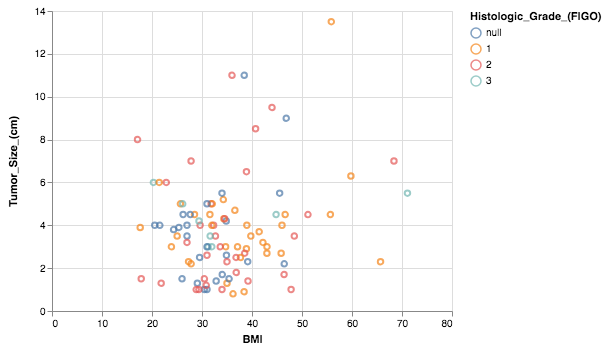

In [6]:
alt.Chart(clinicaldf).mark_point().encode(
    alt.X('BMI', type='quantitative'),
    alt.Y('Tumor_Size_(cm)', type='quantitative'),
    alt.Color('Histologic_Grade_(FIGO)', type='nominal')
).interactive()

### Bar chart

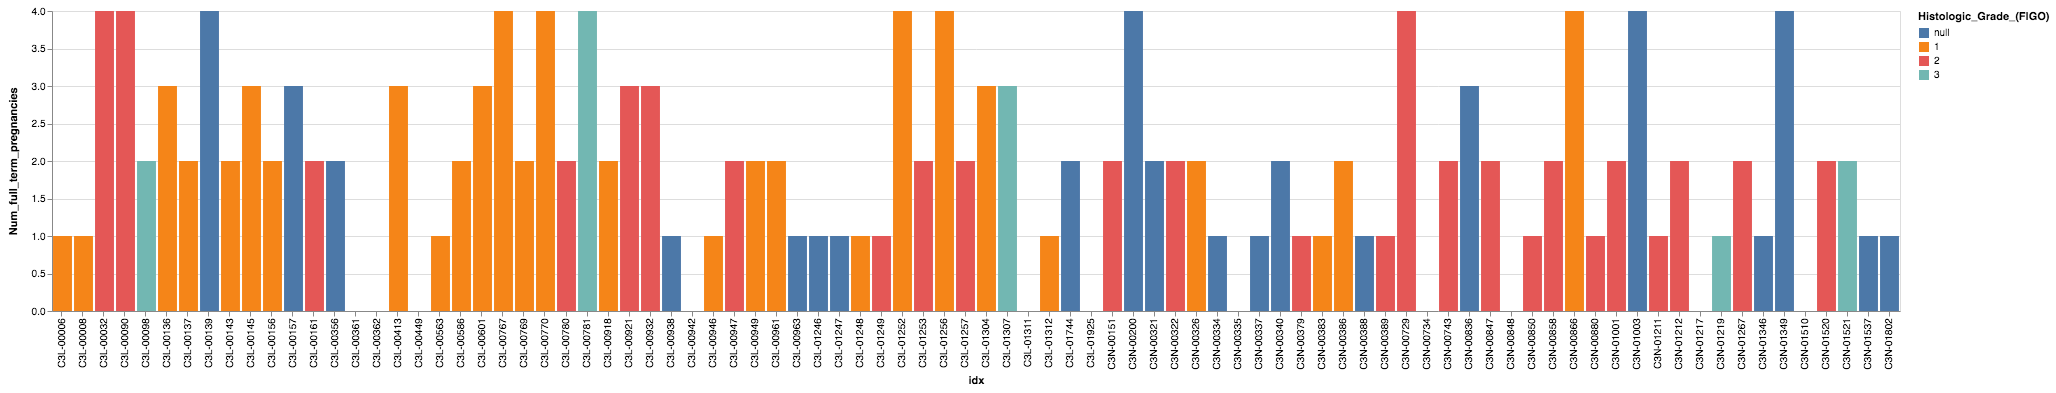

In [7]:
alt.Chart(clinicaldf).mark_bar().encode(
    alt.X('idx', type='nominal'),
    alt.Y('Num_full_term_pregnancies'),
    alt.Color('Histologic_Grade_(FIGO)', type='nominal')
)

# Begin analysis

### Select the clinical phenotype you'd like to use

In [8]:
clinicalCol = 'Tumor_Size_(cm)'

### Determine your p-value cutoff (I use a Bonferroni correction here)

In [9]:
pCutoff = 0.05 / len(clinicaldf.index)
print(pCutoff)

0.0004950495049504951


### Select only the desired column from the clinicaldf and keep the ids

In [10]:
tumor_size = clinicaldf[['idx', clinicalCol]]
tumor_size.head()

,idx,Tumor_Size_(cm)
1,C3L-00006,2.9
2,C3L-00008,3.5
3,C3L-00032,4.5
4,C3L-00090,3.5
5,C3L-00098,6


### Flip it on its side and rename the columns with the correct patient id. 
**Note: Renaming the columns changes it to a different data type, so you have to run to_frame() and transpose it again.**

In [11]:
tumorSize = tumor_size.transpose()
tumorSize.columns = tumorSize.iloc[0]
tumorSize = tumorSize.iloc[1].to_frame().transpose()
tumorSize.head()

idx,C3L-00006,C3L-00008,C3L-00032,C3L-00090,C3L-00098,C3L-00136,C3L-00137,C3L-00139,C3L-00143,C3L-00145,...,C3N-01219,C3N-01267,C3N-01346,C3N-01349,C3N-01510,C3N-01520,C3N-01521,C3N-01537,C3N-01802,C3N-01825
Tumor_Size_(cm),2.9,3.5,4.5,3.5,6,4.5,5,4,5.2,4.7,...,5,1.2,5.5,5,8.5,1,4.2,1.5,3.8,1.7


### Keep only the columns that have .T after the patient id (the clinical data doesn't use .T or .N). Make sure to keep the id column as well

In [12]:
phosTumors = phosdf.filter(regex='(idx)|(\.T)')
phosTumors = phosTumors.rename(columns=lambda x: x.replace('.T', ''))
phosTumors.head()

,idx,C3L-00136,C3L-00098,C3L-00090,C3L-00008,C3L-00032,C3L-00006,C3L-00139,C3L-00143,C3L-00137,...,C3L-01247,C3L-01249,C3L-01246,C3L-01744,C3N-01537,C3N-01825,C3N-01825_rep,C3L-01925,C3N-01346,C3N-01349
0,AAAS-S495,NaN,1.511548,1.112944,NaN,0.817520,NaN,1.418852,0.869111,1.207999,...,0.826702,0.181608,1.235125,1.411036,1.357841,0.906307,NaN,1.423261,1.540822,0.987610
1,AAK1-S18,0.879774,1.556005,NaN,0.692318,1.334778,0.821719,1.336072,0.726407,0.725926,...,1.242041,3.487461,1.420847,NaN,0.687436,0.998162,2.002416,1.007287,1.296941,1.004323
2,AAK1-S20,0.696099,0.964754,0.687200,0.453538,0.966963,1.352040,1.302045,0.880087,0.469054,...,1.859153,1.144811,1.622101,3.446092,0.738936,1.455261,1.917427,0.741597,1.313947,1.000152
3,AAK1-S21,0.914304,0.949023,0.887574,1.068494,0.956485,1.434344,1.239891,0.573554,0.335203,...,1.278922,0.848739,1.475542,0.811320,NaN,1.177364,1.708173,0.503021,NaN,0.598483
4,AAK1-S624,2.024795,1.103993,1.153816,0.631918,0.977280,0.615934,0.856731,1.114945,0.741818,...,1.274481,1.634016,1.087621,0.539889,0.937964,1.937846,2.415771,0.994277,1.410381,0.969571


### Grab only the first row, convert it back to a data frame, and transpose it
**Note: Make sure to rename the first column to the name of the phosphorylation location (second line)**

In [13]:
firstLoc = phosTumors.iloc[0].to_frame().transpose()
firstLoc = firstLoc.rename(index={0:firstLoc.iloc[0,0]})
firstLoc.head()

,idx,C3L-00136,C3L-00098,C3L-00090,C3L-00008,C3L-00032,C3L-00006,C3L-00139,C3L-00143,C3L-00137,...,C3L-01247,C3L-01249,C3L-01246,C3L-01744,C3N-01537,C3N-01825,C3N-01825_rep,C3L-01925,C3N-01346,C3N-01349
AAAS-S495,AAAS-S495,NaN,1.51155,1.11294,NaN,0.81752,NaN,1.41885,0.869111,1.208,...,0.826702,0.181608,1.23513,1.41104,1.35784,0.906307,NaN,1.42326,1.54082,0.98761


### Concatenate the two one-row tables! The data should sort automatically so the columns match up
**Note: It is important to drop all NaN values. Make sure you set axis="columns" otherwise you'll end up with no data**

In [14]:
tSizeFirstLoc = pd.concat([tumorSize, firstLoc], axis = 0, sort=True)
tSizeFirstLoc = tSizeFirstLoc.dropna(axis=1).transpose()
tSizeFirstLoc.head()

,Tumor_Size_(cm),AAAS-S495
C3L-00032,4.5,0.81752
C3L-00090,3.5,1.11294
C3L-00098,6,1.51155
C3L-00137,5,1.208
C3L-00139,4,1.41885


### Plot the data from the table

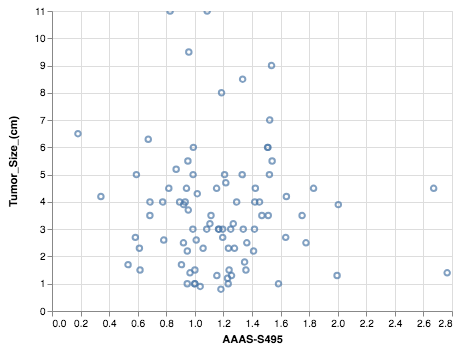

In [15]:
phosSite = tSizeFirstLoc.columns.values[1] + ":Q"
alt.Chart(tSizeFirstLoc).mark_point().encode(
    alt.Y(clinicalCol),
    alt.X(phosSite)
).interactive()

### Use the pandas.DataFrame.corr function to determine correlation

In [16]:
pCorr = tSizeFirstLoc[clinicalCol].astype('float64').corr(tSizeFirstLoc['AAAS-S495'].astype('float64'))
pCorr

-0.058404495674004256

### Now let's create the big table that we will loop through for histologic grade and phosphorylation levels

In [17]:
clinicalColdf = clinicaldf[['idx', clinicalCol]]
clinicalColdf = clinicalColdf.transpose()
clinicalColdf.columns = clinicalColdf.iloc[0]
clinicalColdf = clinicalColdf.iloc[1].to_frame().transpose()
clinicalColdf.head()

idx,C3L-00006,C3L-00008,C3L-00032,C3L-00090,C3L-00098,C3L-00136,C3L-00137,C3L-00139,C3L-00143,C3L-00145,...,C3N-01219,C3N-01267,C3N-01346,C3N-01349,C3N-01510,C3N-01520,C3N-01521,C3N-01537,C3N-01802,C3N-01825
Tumor_Size_(cm),2.9,3.5,4.5,3.5,6,4.5,5,4,5.2,4.7,...,5,1.2,5.5,5,8.5,1,4.2,1.5,3.8,1.7


In [18]:
phosTumors = phosdf.filter(regex='(idx)|(\.T)')
phosTumors = phosTumors.rename(columns=lambda x: x.replace('.T', ''))
phosTumors = phosTumors.set_index('idx')
phosTumors.head()

,C3L-00136,C3L-00098,C3L-00090,C3L-00008,C3L-00032,C3L-00006,C3L-00139,C3L-00143,C3L-00137,C3L-00156,...,C3L-01247,C3L-01249,C3L-01246,C3L-01744,C3N-01537,C3N-01825,C3N-01825_rep,C3L-01925,C3N-01346,C3N-01349
idx,,,,,,,,,,,,,,,,,,,,,
AAAS-S495,NaN,1.511548,1.112944,NaN,0.817520,NaN,1.418852,0.869111,1.207999,0.947326,...,0.826702,0.181608,1.235125,1.411036,1.357841,0.906307,NaN,1.423261,1.540822,0.987610
AAK1-S18,0.879774,1.556005,NaN,0.692318,1.334778,0.821719,1.336072,0.726407,0.725926,1.214033,...,1.242041,3.487461,1.420847,NaN,0.687436,0.998162,2.002416,1.007287,1.296941,1.004323
AAK1-S20,0.696099,0.964754,0.687200,0.453538,0.966963,1.352040,1.302045,0.880087,0.469054,0.846182,...,1.859153,1.144811,1.622101,3.446092,0.738936,1.455261,1.917427,0.741597,1.313947,1.000152
AAK1-S21,0.914304,0.949023,0.887574,1.068494,0.956485,1.434344,1.239891,0.573554,0.335203,0.579155,...,1.278922,0.848739,1.475542,0.811320,NaN,1.177364,1.708173,0.503021,NaN,0.598483
AAK1-S624,2.024795,1.103993,1.153816,0.631918,0.977280,0.615934,0.856731,1.114945,0.741818,0.779409,...,1.274481,1.634016,1.087621,0.539889,0.937964,1.937846,2.415771,0.994277,1.410381,0.969571


In [19]:
singleClinicaldf = pd.concat([clinicalColdf, phosTumors], axis = 0, sort=True)
singleClinicaldf = singleClinicaldf.transpose()
singleClinicaldf.head()

,Tumor_Size_(cm),AAAS-S495,AAK1-S18,AAK1-S20,AAK1-S21,AAK1-S624,AAK1-S637,AAK1-S670,AAK1-S678,AAK1-S682,...,ZZEF1-S1464,ZZEF1-S1488,ZZEF1-S1501,ZZEF1-S1518,ZZEF1-S2444,ZZEF1-T1477,ZZEF1-T1512,ZZEF1-T1521,ZZZ3-S397,ZZZ3-S426
C3L-00006,2.9,NaN,0.821719,1.35204,1.43434,0.615934,0.624679,0.713503,0.740894,0.523559,...,0.823663,0.87033,0.926385,0.925015,0.948549,0.831736,NaN,1.17917,1.33593,0.833387
C3L-00008,3.5,NaN,0.692318,0.453538,1.06849,0.631918,0.748012,0.744204,0.818215,0.761952,...,1.35263,1.29373,1.51129,1.25731,NaN,2.1862,2.00179,1.26739,0.877979,0.684302
C3L-00032,4.5,0.81752,1.33478,0.966963,0.956485,0.97728,1.73528,NaN,0.376517,1.11497,...,2.07341,1.53038,NaN,1.28393,1.44461,1.42989,1.21832,0.827654,NaN,NaN
C3L-00090,3.5,1.11294,NaN,0.6872,0.887574,1.15382,0.88684,1.49998,1.41776,NaN,...,1.02353,0.884547,NaN,1.59942,1.21403,NaN,1.80377,0.803419,1.02033,0.595455
C3L-00098,6,1.51155,1.55601,0.964754,0.949023,1.10399,1.54743,1.43527,0.590696,0.810401,...,0.688586,1.39109,0.615914,1.19357,0.666592,0.632036,0.911677,0.862623,0.932446,1.10916


### Our dataframe is now ready to be looped through

In [21]:
locNames = list(singleClinicaldf)
sigList = list()
corr_cutoff = 0.5
#corr_cutoff = 0.0
for i in range(1, len(list(singleClinicaldf))):
        pCorr = singleClinicaldf[clinicalCol].astype('float64').corr(singleClinicaldf[locNames[i]].astype('float64'))
        if abs(pCorr) > corr_cutoff :
            print("Correlation for " + str(locNames[i]) + ": " + str(pCorr))
            sigList.append(locNames[i])

Correlation for CDC42EP3-T111: 0.5382507599435223


### Select for the one site and drop na values

In [22]:
oneSitedf = singleClinicaldf[[clinicalCol, sigList[0]]]
oneSitedf = oneSitedf.dropna(axis=0)
oneSitedf.head()

,Tumor_Size_(cm),CDC42EP3-T111
C3L-00006,2.9,0.579878
C3L-00090,3.5,0.565198
C3L-00098,6,0.885403
C3L-00143,5.2,0.859096
C3L-00157,4.2,0.314583


### Find the p-value (first number is correlation, second is p-value)

In [23]:
pearsonr(oneSitedf[clinicalCol], oneSitedf[sigList[0]])

(0.5382507599435221, 2.6928319014483863e-05)

### Do this in a loop and select for the ones with p-values below the cutoff

In [24]:
for i in range(0, len(sigList)):
    site = sigList[i]
    oneSitedf = singleClinicaldf[[clinicalCol, site]]
    oneSitedf = oneSitedf.dropna(axis=0)
    pearsonResult = pearsonr(oneSitedf[clinicalCol], oneSitedf[site])
    if (pearsonResult[1] <= pCutoff):
        print(sigList[i])
        print(pearsonResult)

CDC42EP3-T111
(0.5382507599435221, 2.6928319014483863e-05)
